In [1]:
!pip install -q albumentations torchmetrics pytorch-lightning clearml python-dotenv transformers timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.6 MB/s eta 0:00:00


In [2]:
import os
import math
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback, TQDMProgressBar
from torch.utils.data import DataLoader, Dataset
from torchmetrics import JaccardIndex
from albumentations.pytorch import ToTensorV2
from clearml import Task
import cv2
import numpy as np
from transformers import AutoConfig, AutoModel
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from google.colab import files
from dotenv import load_dotenv

In [3]:
from google.colab import userdata, drive

os.environ['CLEARML_API_ACCESS_KEY'] = userdata.get('CLEARML_API_ACCESS_KEY')
os.environ['CLEARML_API_SECRET_KEY'] = userdata.get('CLEARML_API_SECRET_KEY')

In [4]:
drive.mount('/content/drive')


source_path = '/content/drive/MyDrive/'

tasks = [
    {
        "files": ["leftImg8bit_trainvaltest.zip", "gtFine_trainvaltest.zip"],
        "dest": "/content/data/cityscapes/"
    }
]

for task in tasks:
    if not os.path.exists(task["dest"]):
        os.makedirs(task["dest"])

    for zip_file in task["files"]:
        full_path = os.path.join(source_path, zip_file)

        if os.path.exists(full_path):
            print(f"Unpacking {zip_file} in {task['dest']}...")
            !unzip -q -o "{full_path}" -d "{task['dest']}"
        else:
            print(f"Error, file not found: {full_path}")

Mounted at /content/drive
Unpacking leftImg8bit_trainvaltest.zip in /content/data/cityscapes/...
Unpacking gtFine_trainvaltest.zip in /content/data/cityscapes/...


In [5]:
CONFIG = {
    "project_name": "Segmentation_Urban_Scene_CourseWork",
    "task_name": "InternImage_Tiny_Cityscapes",
    "data_dir": "./data/cityscapes",
    "model_name": "OpenGVLab/internimage_t_1k_224",
    "classes": 19,
    "batch_size": 8,
    "lr": 1e-4,
    "weight_decay": 0.05,
    "epochs": 50,
    "warmup_epochs": 2,
    "head_lr_multiplier": 10.0,
    "image_size": (512, 1024),
    "freeze_backbone": False,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Set precision for Tensor Cores
torch.set_float32_matmul_precision('medium')

# Set allocator to avoid fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

task = Task.init(
    project_name=CONFIG["project_name"],
    task_name=CONFIG["task_name"],
    output_uri=False
)
task.connect(CONFIG)

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


ClearML Task: created new task id=b34a969fefb24a5d86c03fac7a2518f2


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


ClearML results page: https://app.clear.ml/projects/588d5d925230490b9f98b1007b4c7fa0/experiments/b34a969fefb24a5d86c03fac7a2518f2/output/log


{'project_name': 'Segmentation_Urban_Scene_CourseWork',
 'task_name': 'InternImage_Tiny_Cityscapes',
 'data_dir': './data/cityscapes',
 'model_name': 'OpenGVLab/internimage_t_1k_224',
 'classes': 19,
 'batch_size': 8,
 'lr': 0.0001,
 'weight_decay': 0.05,
 'epochs': 50,
 'warmup_epochs': 2,
 'head_lr_multiplier': 10.0,
 'image_size': (512, 1024),
 'freeze_backbone': False,
 'device': 'cuda'}

In [6]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', augmentation=None):
        self.root_dir = root_dir
        self.images_dir = os.path.join(root_dir, 'leftImg8bit', split)
        self.masks_dir = os.path.join(root_dir, 'gtFine', split)
        self.augmentation = augmentation
        self.ids = []

        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            mask_dir = os.path.join(self.masks_dir, city)
            for file_name in os.listdir(img_dir):
                if file_name.endswith('_leftImg8bit.png'):
                   self.ids.append({
                       'image': os.path.join(img_dir, file_name),
                       'mask': os.path.join(mask_dir, file_name.replace('_leftImg8bit.png', '_gtFine_labelIds.png'))
                   })

        # Cityscapes to training labels mapping
        self.mapping = {
            7: 0, 8: 1, 11: 2, 12: 3, 13: 4, 17: 5, 19: 6, 20: 7, 21: 8, 22: 9,
            23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 31: 16, 32: 17, 33: 18
        }

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, i):
        sample = self.ids[i]
        image = cv2.imread(sample['image'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(sample['mask'], 0)

        # Map Cityscapes labels to training labels
        mask_mapped = np.ones_like(mask) * 255
        for k, v in self.mapping.items():
            mask_mapped[mask == k] = v
        mask = mask_mapped

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask.long()

In [7]:
class RoadDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, image_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size

    def setup(self, stage=None):
        self.train_transform = A.Compose([
            A.Resize(height=512, width=1024),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.valid_transform = A.Compose([
            A.Resize(height=512, width=1024),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

        self.train_ds = CityscapesDataset(
            self.data_dir,
            split='train',
            augmentation=self.train_transform
        )
        self.val_ds = CityscapesDataset(
            self.data_dir,
            split='val',
            augmentation=self.valid_transform
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

In [8]:
class SimpleSegmentationHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, num_classes, kernel_size=1)
        )

    def forward(self, x, h, w):
        logits = self.block(x)
        logits = F.interpolate(logits, size=(h, w), mode="bilinear", align_corners=False)
        return logits


class ClearMLMetricsCallback(Callback):
    def __init__(self, task):
        super().__init__()
        self._logger = task.get_logger()

    def _log_metrics(self, trainer, stage):
        for name, value in trainer.callback_metrics.items():
            if isinstance(value, torch.Tensor):
                value = value.detach().cpu().item()
            if isinstance(value, (int, float)) and math.isfinite(value):
                self._logger.report_scalar(stage, name, value, iteration=trainer.current_epoch)

    def on_train_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "train")

    def on_validation_epoch_end(self, trainer, pl_module):
        self._log_metrics(trainer, "val")


class RoadModel(pl.LightningModule):
    def __init__(
        self,
        model_name="OpenGVLab/internimage_t_1k_224",
        num_classes=19,
        lr=6e-5,
        weight_decay=0.05,
        epochs=50,
        warmup_epochs=2,
        head_lr_multiplier=10.0,
        freeze_backbone=False,
    ):
        super().__init__()
        self.save_hyperparameters()

        cfg = AutoConfig.from_pretrained(
            model_name,
            trust_remote_code=True,
        )
        self.backbone = AutoModel.from_config(
            cfg,
            trust_remote_code=True,
        )
        weights_path = hf_hub_download(
            repo_id=model_name,
            filename="model.safetensors",
        )
        state_dict = load_file(weights_path)
        self.backbone.load_state_dict(state_dict, strict=False)

        cfg = self.backbone.config
        self.feature_channels = int(cfg.channels * (2 ** (len(cfg.depths) - 1)))

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone frozen!")

        self.segmentation_head = SimpleSegmentationHead(
            in_channels=self.feature_channels,
            num_classes=num_classes
        )

        self.criterion = nn.CrossEntropyLoss(ignore_index=255)

        self.train_miou = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=255)
        self.val_miou = JaccardIndex(task="multiclass", num_classes=num_classes, ignore_index=255)

    def forward(self, x):
        _, _, h, w = x.shape
        outputs = self.backbone(pixel_values=x)

        if isinstance(outputs, dict):
            feat = outputs.get("last_hidden_state")
            if feat is None:
                feat = outputs["hidden_states"][-1]
        else:
            feat = outputs.last_hidden_state

        logits = self.segmentation_head(feat, h, w)
        return logits

    def training_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)

        loss = self.criterion(logits, masks)

        preds = torch.argmax(logits, dim=1)
        miou = self.train_miou(preds, masks)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_miou", miou, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks = batch
        logits = self(images)

        loss = self.criterion(logits, masks)

        preds = torch.argmax(logits, dim=1)
        miou = self.val_miou(preds, masks)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_miou", miou, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        if self.hparams.freeze_backbone:
            params = self.segmentation_head.parameters()
        else:
            params = [
                {
                    "params": self.backbone.parameters(),
                    "lr": self.hparams.lr,
                },
                {
                    "params": self.segmentation_head.parameters(),
                    "lr": self.hparams.lr * self.hparams.head_lr_multiplier,
                },
            ]

        optimizer = torch.optim.AdamW(
            params,
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
            betas=(0.9, 0.999),
            eps=1e-8,
        )

        if self.hparams.warmup_epochs > 0:
            warmup = torch.optim.lr_scheduler.LinearLR(
                optimizer,
                start_factor=1e-3,
                total_iters=self.hparams.warmup_epochs,
            )
            poly_iters = max(1, self.hparams.epochs - self.hparams.warmup_epochs)
            main = torch.optim.lr_scheduler.PolynomialLR(
                optimizer,
                total_iters=poly_iters,
                power=1.0,
            )
            scheduler = torch.optim.lr_scheduler.SequentialLR(
                optimizer,
                schedulers=[warmup, main],
                milestones=[self.hparams.warmup_epochs],
            )
        else:
            scheduler = torch.optim.lr_scheduler.PolynomialLR(
                optimizer,
                total_iters=self.hparams.epochs,
                power=1.0,
            )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
            },
        }

In [9]:
dm = RoadDataModule(
    CONFIG["data_dir"],
    CONFIG["batch_size"],
    CONFIG["image_size"]
)

model = RoadModel(
    model_name=CONFIG["model_name"],
    num_classes=CONFIG["classes"],
    lr=CONFIG["lr"],
    weight_decay=CONFIG["weight_decay"],
    epochs=CONFIG["epochs"],
    warmup_epochs=CONFIG["warmup_epochs"],
    head_lr_multiplier=CONFIG["head_lr_multiplier"],
    freeze_backbone=CONFIG["freeze_backbone"],
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_miou",
    dirpath="./checkpoints",
    filename="internimage-tiny-cityscapes-{epoch:02d}-{val_miou:.4f}",
    save_top_k=1,
    mode="max",
)

trainer = pl.Trainer(
    max_epochs=CONFIG["epochs"],
    accelerator="gpu",
    devices=1,
    logger=True,
    callbacks=[
        checkpoint_callback,
        TQDMProgressBar(refresh_rate=20),
        ClearMLMetricsCallback(task)
    ],
    precision="16-mixed",
    accumulate_grad_batches=4
)

trainer.fit(model, datamodule=dm)

config.json: 0.00B [00:00, ?B/s]

configuration_internimage.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/internimage_t_1k_224:
- configuration_internimage.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_internimage.py: 0.00B [00:00, ?B/s]

dcnv3.py: 0.00B [00:00, ?B/s]

dcnv3_func.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/internimage_t_1k_224:
- dcnv3_func.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/internimage_t_1k_224:
- dcnv3.py
- dcnv3_func.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/OpenGVLab/internimage_t_1k_224:
- modeling_internimage.py
- dcnv3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:49: FutureWarning:

Importing from timm.models.layers is deprec

DCNv3 is not installed, using PyTorch implementation.
using core type: DCNv3
level2_post_norm: False
level2_post_norm_block_ids: None
res_post_norm: False
remove_center: False


model.safetensors:   0%|          | 0.00/120M [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: UserWarning:

Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.



┏━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name              ┃ Type                   ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone          │ InternImageModel       │ 28.8 M │ train │     0 │
│ 1 │ segmentation_head │ SimpleSegmentationHead │  2.4 M │ train │     0 │
│ 2 │ criterion         │ CrossEntropyLoss       │      0 │ train │     0 │
│ 3 │ train_miou        │ MulticlassJaccardIndex │      0 │ train │     0 │
│ 4 │ val_miou          │ MulticlassJaccardIndex │      0 │ train │     0 │
└───┴───────────────────┴────────────────────────┴────────┴───────┴───────┘

Trainable params: 31.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 31.1 M                                                                                               
Total estimated model params size (MB): 124                                                                        
Modules in train mode: 716                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/call.py", line 49, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 630, in _fit_impl
    self._run(model, ckpt_path=ckpt_path, weights_only=weights_only)
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1079, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/trainer/trainer.py", line 1123, in _run_stage
    self.fit_loop.run()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 217, in run
    self.advance()
  File "/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py", line 465, in advance
    self.epoch_loop.run(self._data_fetcher)
  File

TypeError: object of type 'NoneType' has no len()

DCNv3 is not installed, using PyTorch implementation.
using core type: DCNv3
level2_post_norm: False
level2_post_norm_block_ids: None
res_post_norm: False
remove_center: False


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.21424728631973267    │
│         val_miou          │    0.5509527921676636     │
└───────────────────────────┴───────────────────────────┘


Results:



,Metric,Value
0,Loss,0.2142
1,mIoU,0.5510
2,Percent,55.10%


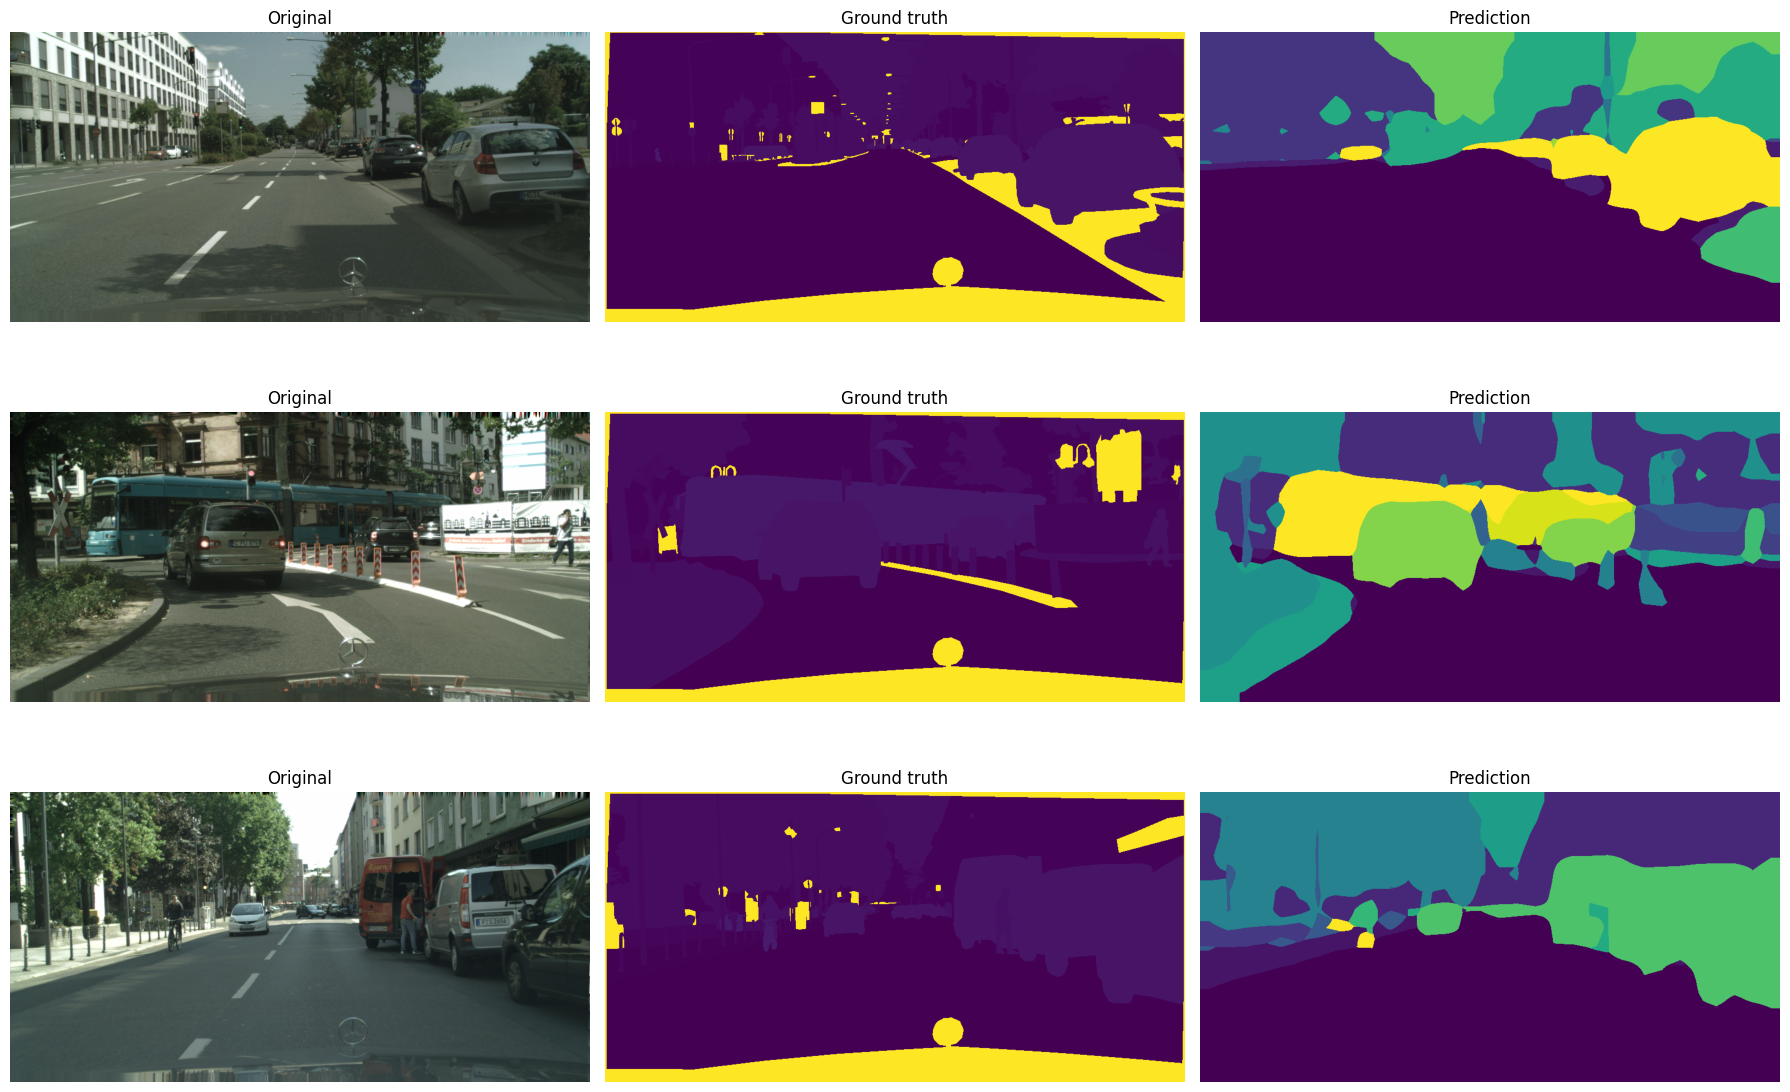

In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path

best_model = RoadModel.load_from_checkpoint(best_model_path)
best_model.to(CONFIG["device"])
best_model.eval()

# Validate the best model
val_results = trainer.validate(best_model, datamodule=dm)[0]

metrics_data = {
    "Metric": ["Loss", "mIoU", "Percent"],
    "Value": [
        f"{val_results['val_loss']:.4f}",
        f"{val_results['val_miou']:.4f}",
        f"{val_results['val_miou']*100:.2f}%"
    ]
}
df = pd.DataFrame(metrics_data)

print("\n" + "="*30)
print("Results:" + "\n")
print("="*30)
display(df)

def visualize_predictions(model, datamodule, num_samples=3):
    model.to(CONFIG["device"])
    model.eval()

    val_loader = datamodule.val_dataloader()
    images, masks = next(iter(val_loader))

    images = images.to(CONFIG["device"])
    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    images = images.cpu()
    masks = masks.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(18, num_samples * 4))

    for i in range(min(num_samples, len(images))):
        # Denormalize image for visualization
        img = images[i].permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i])
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(preds[i])
        plt.title(f"Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_predictions(best_model, dm)

In [11]:
best_model_path = trainer.checkpoint_callback.best_model_path

model_name = os.path.basename(best_model_path)

current_task = Task.get_task(task_id=task.id)

current_task.update_output_model(
    model_path=best_model_path,
    model_name=model_name,
    iteration=trainer.current_epoch
)

'https://files.clear.ml/Segmentation_Urban_Scene_CourseWork/InternImage_Tiny_Cityscapes.b34a969fefb24a5d86c03fac7a2518f2/models/internimage-tiny-cityscapes-epoch=39-val_miou=0.5510.ckpt'

In [12]:
task.close()


████▏                           14% | 50.00/356.96 MB [00:01<00:07, 42.20MB/s]: 
████▌                           15% | 55.00/356.96 MB [00:01<00:07, 41.49MB/s]: 
█████                           17% | 60.00/356.96 MB [00:01<00:07, 41.40MB/s]: 
█████▍                          18% | 65.00/356.96 MB [00:01<00:07, 41.33MB/s]: 
█████▉                          20% | 70.00/356.96 MB [00:01<00:06, 41.29MB/s]: 
██████▎                         21% | 75.00/356.96 MB [00:01<00:06, 41.26MB/s]: 
██████▋                         22% | 80.00/356.96 MB [00:01<00:06, 41.23MB/s]: 
███████▏                        24% | 85.00/356.96 MB [00:01<00:06, 41.20MB/s]: 
███████▌                        25% | 90.00/356.96 MB [00:02<00:14, 18.84MB/s]: 
███████▉                        27% | 95.00/356.96 MB [00:02<00:11, 22.48MB/s]: 
████████                       28% | 100.00/356.96 MB [00:02<00:09, 26.02MB/s]: 
████████▌                      29% | 105.00/356.96 MB [00:02<00:08, 29.28MB/s]: 
████████▉                  